**ENTENDER O PROBLEMA**

- Objetivo do Problema:
    - Previsão do primeiro destino que um novo usuario ira escolher.
    
    - Porque?
        - Qual o tipo de modelo de negocio do Airbnb?
        
            - Marketplace ( Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação )
            - Oferta ( pessoas oferecendo acomodação )
                - Tamanho do portfólio.
                - Diversidade/Densidade de Portifolio.
                - Preco Medio
                
            - Demanda ( pessoas procurando acomodação )
                - Numero de usuario
                - LTV ( Lifetime Value )
                - CAC ( Client Acquisition Cost )
                
                <font color='red'>**Receita Bruta**</font> =  ( Taxa*NúmeroDeClientes ) - CAC

             
             
- Proposta de Solução
    - Modelo de Previsão do primeiro destino de um novo usuario.
        - Predicoes e salva em uma tabela do banco de dados.
        - API
            - Input: Usuario e suas caracteristicas.
            - Output: Usuario e suas caracteristicas com a **predicao de destino** 
            

- Total de Ciclos ( CRISPM ):
    - 16 ciclos.
    

# IMPORTS

In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt


from IPython.display       import Image
from IPython.core.display  import HTML

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [94]:
def jupyter_settings():
    %matplotlib inline
    %matplotlib notebook
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

## Loading Data

In [95]:
df_raw = pd.read_csv('./data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [96]:
# df_sessions = pd.read_csv('./data/sessions.csv', low_memory=True)
# df_sessions.shape

# df_sessions[df_sessions['user_id'] == "00023iyk9l"][['user_id', 'action']].groupby('user_id').value_counts()

# DATA DESCRIPTION

In [97]:
df1 = df_raw

In [98]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 213451
number of columns: 16


## Data Types

In [99]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## NA Check

In [100]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [101]:
df1 = df1.dropna()
df1.shape

(68171, 16)

## Change Data Type

In [102]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

In [103]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [104]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# DATA FILTERING

In [105]:
df2 = df1.copy()

## Filtering Rows

## Columns Selection

# DATA PREPARATION

In [135]:
df3 = df2.copy()

In [136]:
# dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))

# join id and country_destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis=1)

# FEATURE SELECTION

In [139]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # origial dates
df4 = df3.drop( cols_drop, axis=1)

# NEURAL NETWORK - MULTI-LAYER PERCEPTRON

In [140]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [141]:
# split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [142]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

In [143]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [144]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train mode
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.4160 - accuracy: 0.6981
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2813 - accuracy: 0.7067
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2382 - accuracy: 0.7083
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2229 - accuracy: 0.7079
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1981 - accuracy: 0.7084
Epoch 6/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1805 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1666 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1509 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1423 - accuracy: 0.7088
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

# NEURAL NETWORK PERFORMANCE

In [147]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

427/427 [==============================] - 0s 1ms/step


Accuracy: 0.7028969563623029


<IPython.core.display.Javascript object>


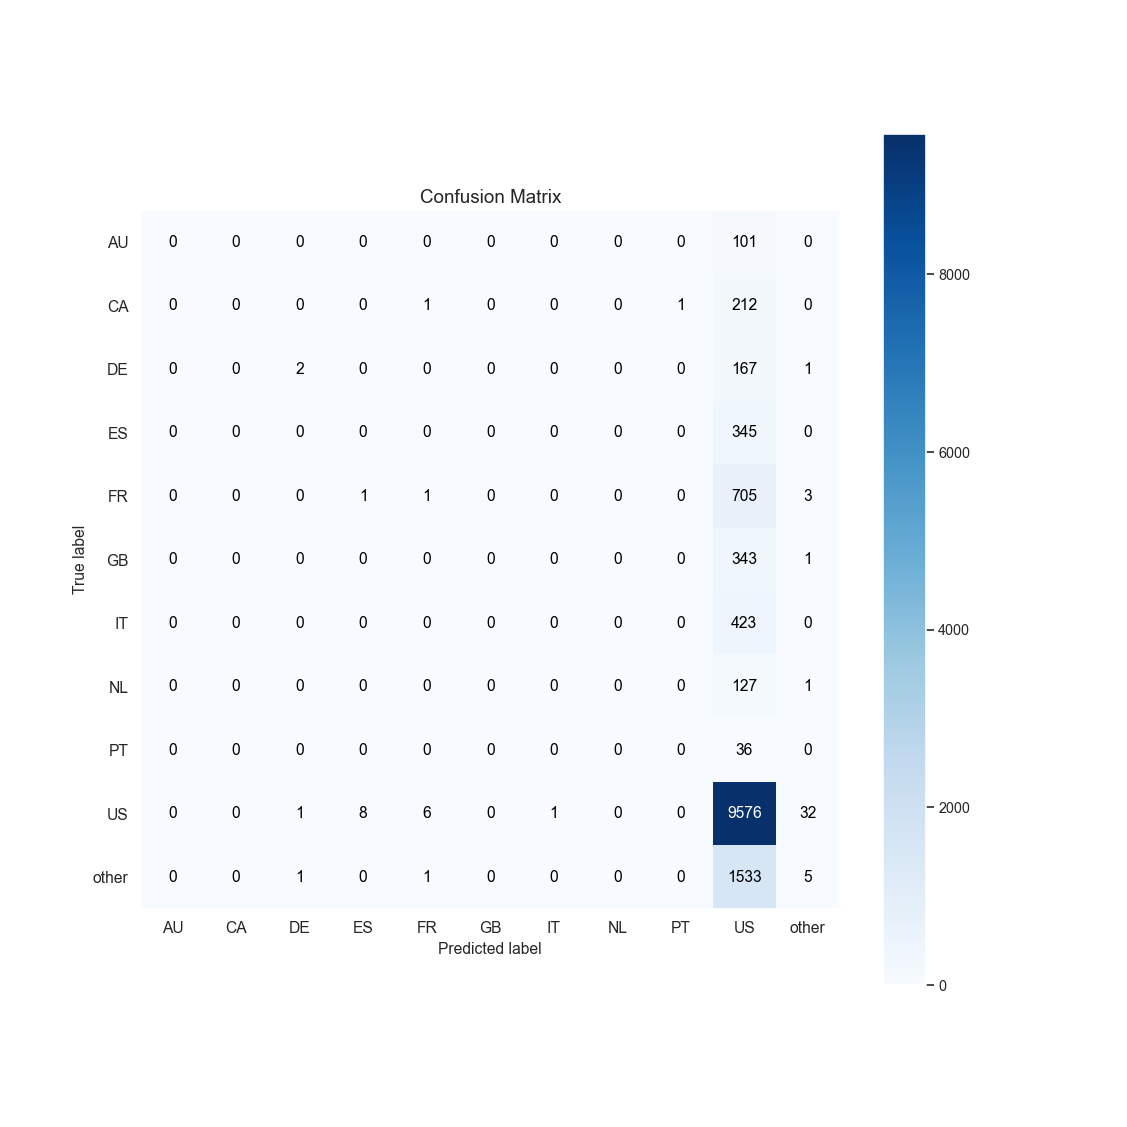

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [152]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

# Balanced Accuracy
# F-Score Balanced
# Recall-Precison
# ROC
# Kappa Metrics
# Matthew Metrics 